In [1]:
import torch
if torch.backends.mps.is_available():
    mps_device = torch.device("mps")
    x = torch.ones(1, device=mps_device)
    print (x)
elif torch.cuda.is_available():
    device = torch.device("cuda")
    x = torch.ones(1, device=device)
    print (x)
else:
    device = torch.device("cpu")
    x = torch.ones(1, device=device)

tensor([1.], device='mps:0')


# Loading a saved model

In [5]:
import os
import json
import joblib
import torch
import ipywidgets as widgets
from IPython.display import display, clear_output
from torch.optim.lr_scheduler import ReduceLROnPlateau

# ─── Make sure your MODEL_FACTORY is in scope ────────────────────────
# from your_module import MODEL_FACTORY

# 1) Device
device = torch.device(
    "cuda" if torch.cuda.is_available() else
    "mps"  if torch.backends.mps.is_available() else
    "cpu"
)

# 2) Gather saved runs
models_dir = "models"
runs = sorted(
    d for d in os.listdir(models_dir)
    if os.path.isdir(os.path.join(models_dir, d))
)

dd  = widgets.Dropdown(options=runs, description="Run:", layout=widgets.Layout(width="60%"))
btn = widgets.Button(description="Load", button_style="success")
out = widgets.Output()

# 3) Scheduler factory for future‐proofing
SCHEDULER_FACTORY = {
    "ReduceLROnPlateau": lambda opt, cfg: ReduceLROnPlateau(
        opt,
        mode     = cfg.get("mode",     "min"),
        factor   = cfg.get("factor",   0.5),
        patience = cfg.get("patience", 5),
        min_lr   = cfg.get("min_lr",   1e-7)
    ),
    # add other schedulers here as needed
}

def on_load(_):
    run     = dd.value
    run_dir = os.path.join(models_dir, run)

    # a) Load JSON summary
    with open(os.path.join(run_dir, "test_summary.json"), "r") as f:
        summary = json.load(f)
    hp         = summary["hyperparams"]
    feat_meta  = summary["features"]
    sched_meta = summary["scheduler"]
    metrics    = summary.get("metrics", {})

    time_feats  = feat_meta.get("time_feats", [])
    other_feats = feat_meta["other_feats"]
    all_feats   = time_feats + other_feats

    # Update num_feats just in case:
    num_feats = len(all_feats)

    # c) Rebuild model
    model_cls = MODEL_FACTORY[hp["model"]]
    model     = model_cls(
                    num_feats   = num_feats,
                    hidden_size = hp["hidden_size"],
                    num_layers  = hp["num_layers"],
                    seq_len     = hp["seq_len"]
                ).to(device)

    # d) Rebuild optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=hp["learning_rate"])

    # e) Rebuild scheduler via factory
    scheduler = SCHEDULER_FACTORY[sched_meta["type"]](optimizer, sched_meta)

    # f) Load PyTorch weights
    ckpt = torch.load(
        os.path.join(run_dir, "torch_model.pt"),
        map_location=device,
        weights_only=False
    )
    model.load_state_dict(    ckpt["model_state_dict"]    )
    optimizer.load_state_dict(ckpt["optimizer_state_dict"])
    scheduler.load_state_dict(ckpt["scheduler_state_dict"])
    model.to(device)

    # g) Load sklearn objects
    scikit = joblib.load(os.path.join(run_dir, "scikit_objects.joblib"))
    transformer = scikit["transformer"]
    scaler_y    = scikit["scaler_y"]

    # h) Expose to globals
    globals().update({
        "model":       model,
        "optimizer":   optimizer,
        "scheduler":   scheduler,
        "transformer": transformer,
        "scaler_y":    scaler_y,
        "summary":     summary,
        "base_dir":    run_dir,
        "time_feats": time_feats,
        "other_feats": other_feats,
        "all_feats":   all_feats,
        "horizon":     hp["horizon"],
    })

    with out:
        clear_output()
        print(f"✅ Loaded run '{run}' on {device}\n")
        print("Hyperparameters:")
        print(json.dumps(hp, indent=2))
        print("\nScheduler settings:")
        print(json.dumps(sched_meta, indent=2))
        print("\nMetrics:")
        print(json.dumps({k: round(v,3) for k, v in metrics.items()}, indent=2))

btn.on_click(on_load)
display(dd, btn, out)


Dropdown(description='Run:', layout=Layout(width='60%'), options=('1_SA_BiLSTM_MaxAbs_Huber_lr.0001_bs128_hs64…

Button(button_style='success', description='Load', style=ButtonStyle())

Output()

# Testing Only

In [6]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from torch.utils.data import DataLoader

# Pull hyperparams from summary
seq_len    = summary['hyperparams']['seq_len']
batch_size = summary['hyperparams']['batch_size']

# 1) Transform test set (X_test, y_test already in memory)
X_te_np = transformer.transform(X_test)
y_te_np = scaler_y.transform(y_test.values.reshape(-1,1)).flatten()

# 2) Build DataLoader
test_loader = DataLoader(
    LSTMDataset(X_te_np, y_te_np, seq_len),
    batch_size=batch_size, shuffle=False
)

# 3) Inference
model.eval()
scaled_preds, scaled_trues = [], []
with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        p  = model(xb).cpu().numpy()
        scaled_preds.append(p)
        scaled_trues.append(yb.numpy())
scaled_preds = np.concatenate(scaled_preds)
scaled_trues = np.concatenate(scaled_trues)

# 4) Inverse‐scale back to original units
preds_orig = scaler_y.inverse_transform(scaled_preds.reshape(-1,1)).flatten()
trues_orig = scaler_y.inverse_transform(scaled_trues.reshape(-1,1)).flatten()

# 5) Compute metrics
mae_val  = mean_absolute_error(trues_orig, preds_orig)
rmse_val = np.sqrt(mean_squared_error(trues_orig, preds_orig))
smape_val = np.mean(2.0 * np.abs(trues_orig - preds_orig) /
                    (np.abs(trues_orig) + np.abs(preds_orig) + 1e-8)) * 100
r2 = r2_score(trues_orig, preds_orig)

print(f"Test MAE:   £{mae_val:.2f}")
print(f"Test RMSE:  £{rmse_val:.2f}")
print(f"Test sMAPE: {smape_val:.2f}%")
print(f"Test R²:     {r2:.3f}")

Test MAE:   £15.99
Test RMSE:  £22.70
Test sMAPE: 36.00%
Test R²:     0.694


# Plots

In [7]:
import os
import matplotlib.pyplot as plt

# Create plots directory in the current model run directory
plots_dir = os.path.join(base_dir, "plots")
os.makedirs(plots_dir, exist_ok=True)

# Also keep a general plots directory for cases when no model is loaded
os.makedirs("plots", exist_ok=True)

plt.rcParams.update({
    # Resolution
    "figure.dpi": 300,
    # Font
    "font.family": "Times New Roman",
    "mathtext.fontset": "stix",
    # Figure size (optional – adjust as needed)
    "figure.figsize": (10, 6),
    # Title and label font sizes
    "figure.titlesize": 18,    # overall figure title
    "axes.titlesize": 18,      # axes title
    "axes.labelsize": 14,      # x/y axis labels
    # Tick label size
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    # Legend
    "legend.fontsize": 12,
    # Line width (for plot lines)
    "lines.linewidth": 1.5,
    # Grid styling (optional)
    "axes.grid": True,
    "grid.linestyle": "--",
    "grid.alpha": 0.3,
})



## Predicted vs. True

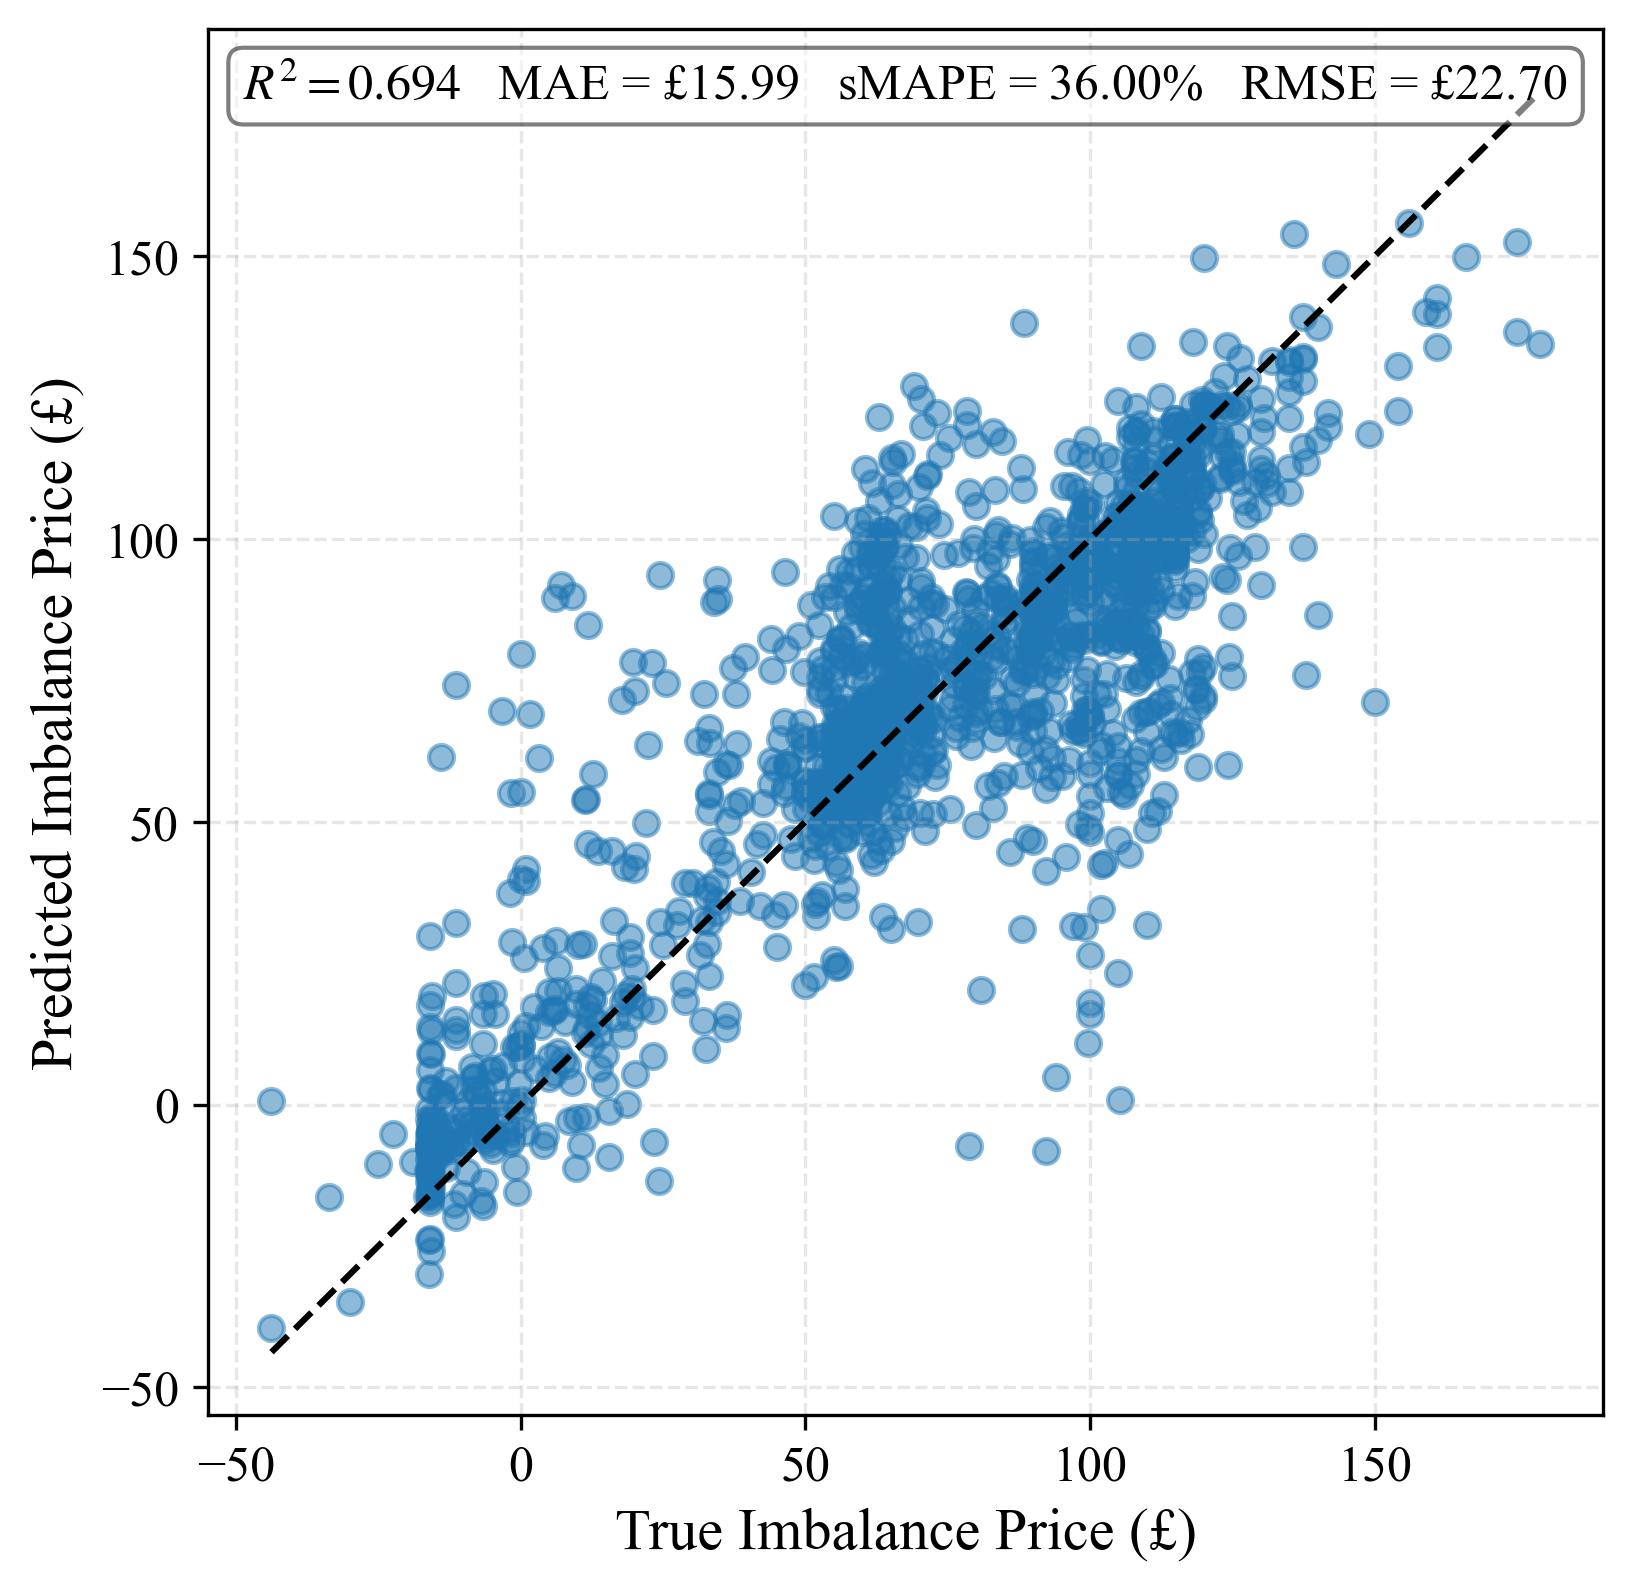

In [8]:
plt.figure(figsize=(6,6))
plt.scatter(trues_orig, preds_orig, alpha=0.5)
mn, mx = trues_orig.min(), trues_orig.max()
plt.plot([mn, mx], [mn, mx], 'k--')
plt.xlabel('True Imbalance Price (£)')
plt.ylabel('Predicted Imbalance Price (£)')

# Add pseudo-legend in a horizontal line
textstr = (
    rf'$R^2 = {r2:.3f}$   '
    f'MAE = £{mae_val:.2f}   '
    f'sMAPE = {smape_val:.2f}%   '
    f'RMSE = £{rmse_val:.2f}'
)
props = dict(boxstyle='round', facecolor='white', alpha=0.5)
plt.gca().text(0.5, 0.95, textstr, transform=plt.gca().transAxes, fontsize=12,
               horizontalalignment='center', bbox=props)

plt.grid(True)
plt.savefig(os.path.join(plots_dir, "predicted_vs_true.png"), dpi=300)
plt.show()

## Residuals Histogram

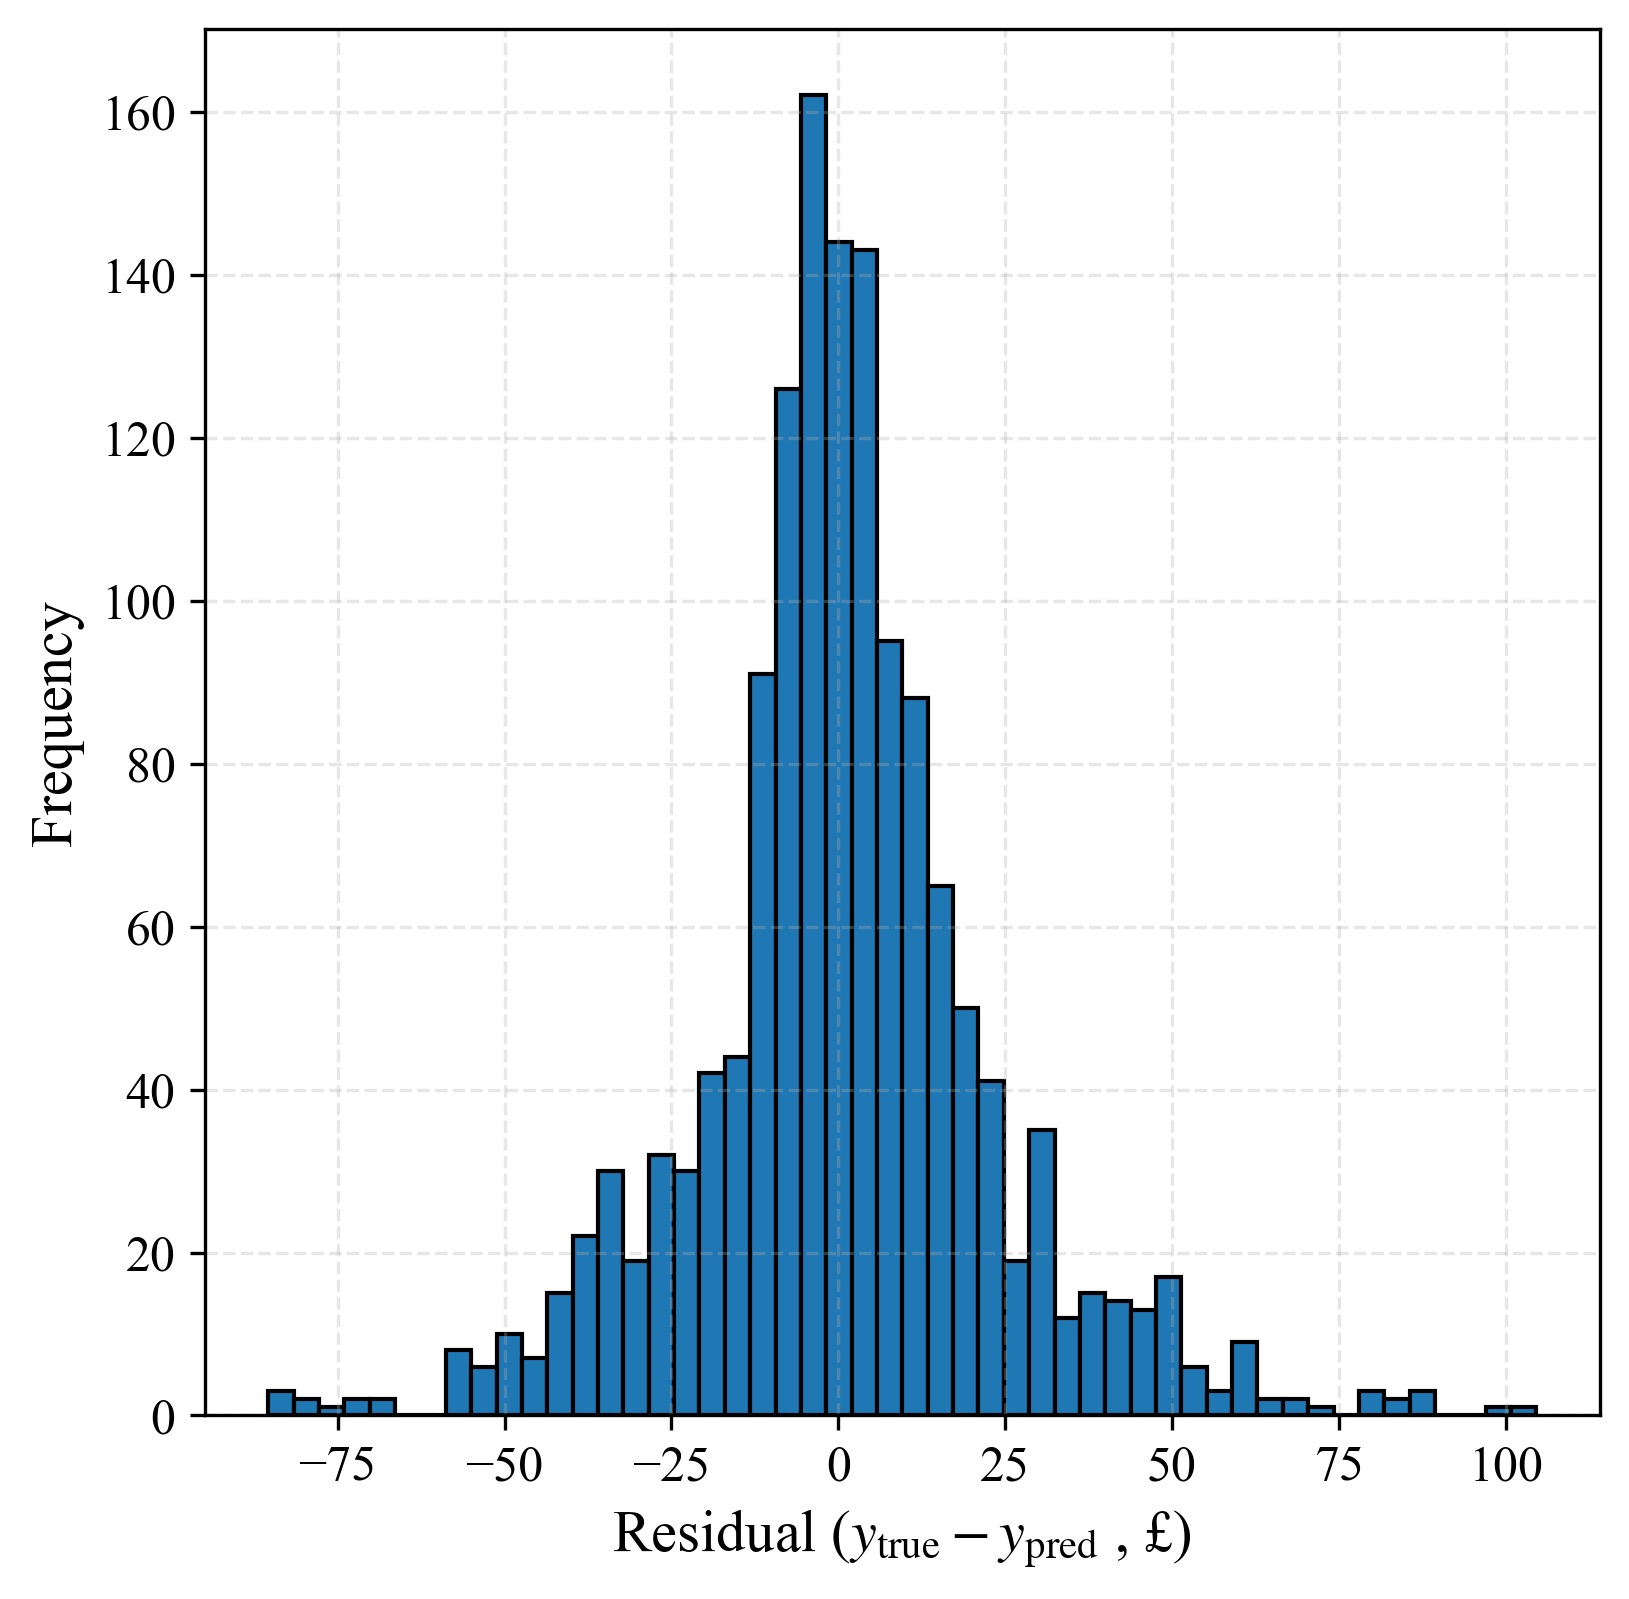

In [9]:
residuals = trues_orig - preds_orig
plt.figure(figsize=(6,6))
plt.hist(residuals, bins=50, edgecolor='black')
plt.xlabel(r'Residual ($y_{\text{true}} - y_{\text{pred}}$ , £)')
plt.ylabel('Frequency')
plt.grid(True)
plt.savefig(os.path.join(plots_dir, "residuals_histogram.png"), dpi=300)
plt.show()

## True vs. Predicted - Time Series

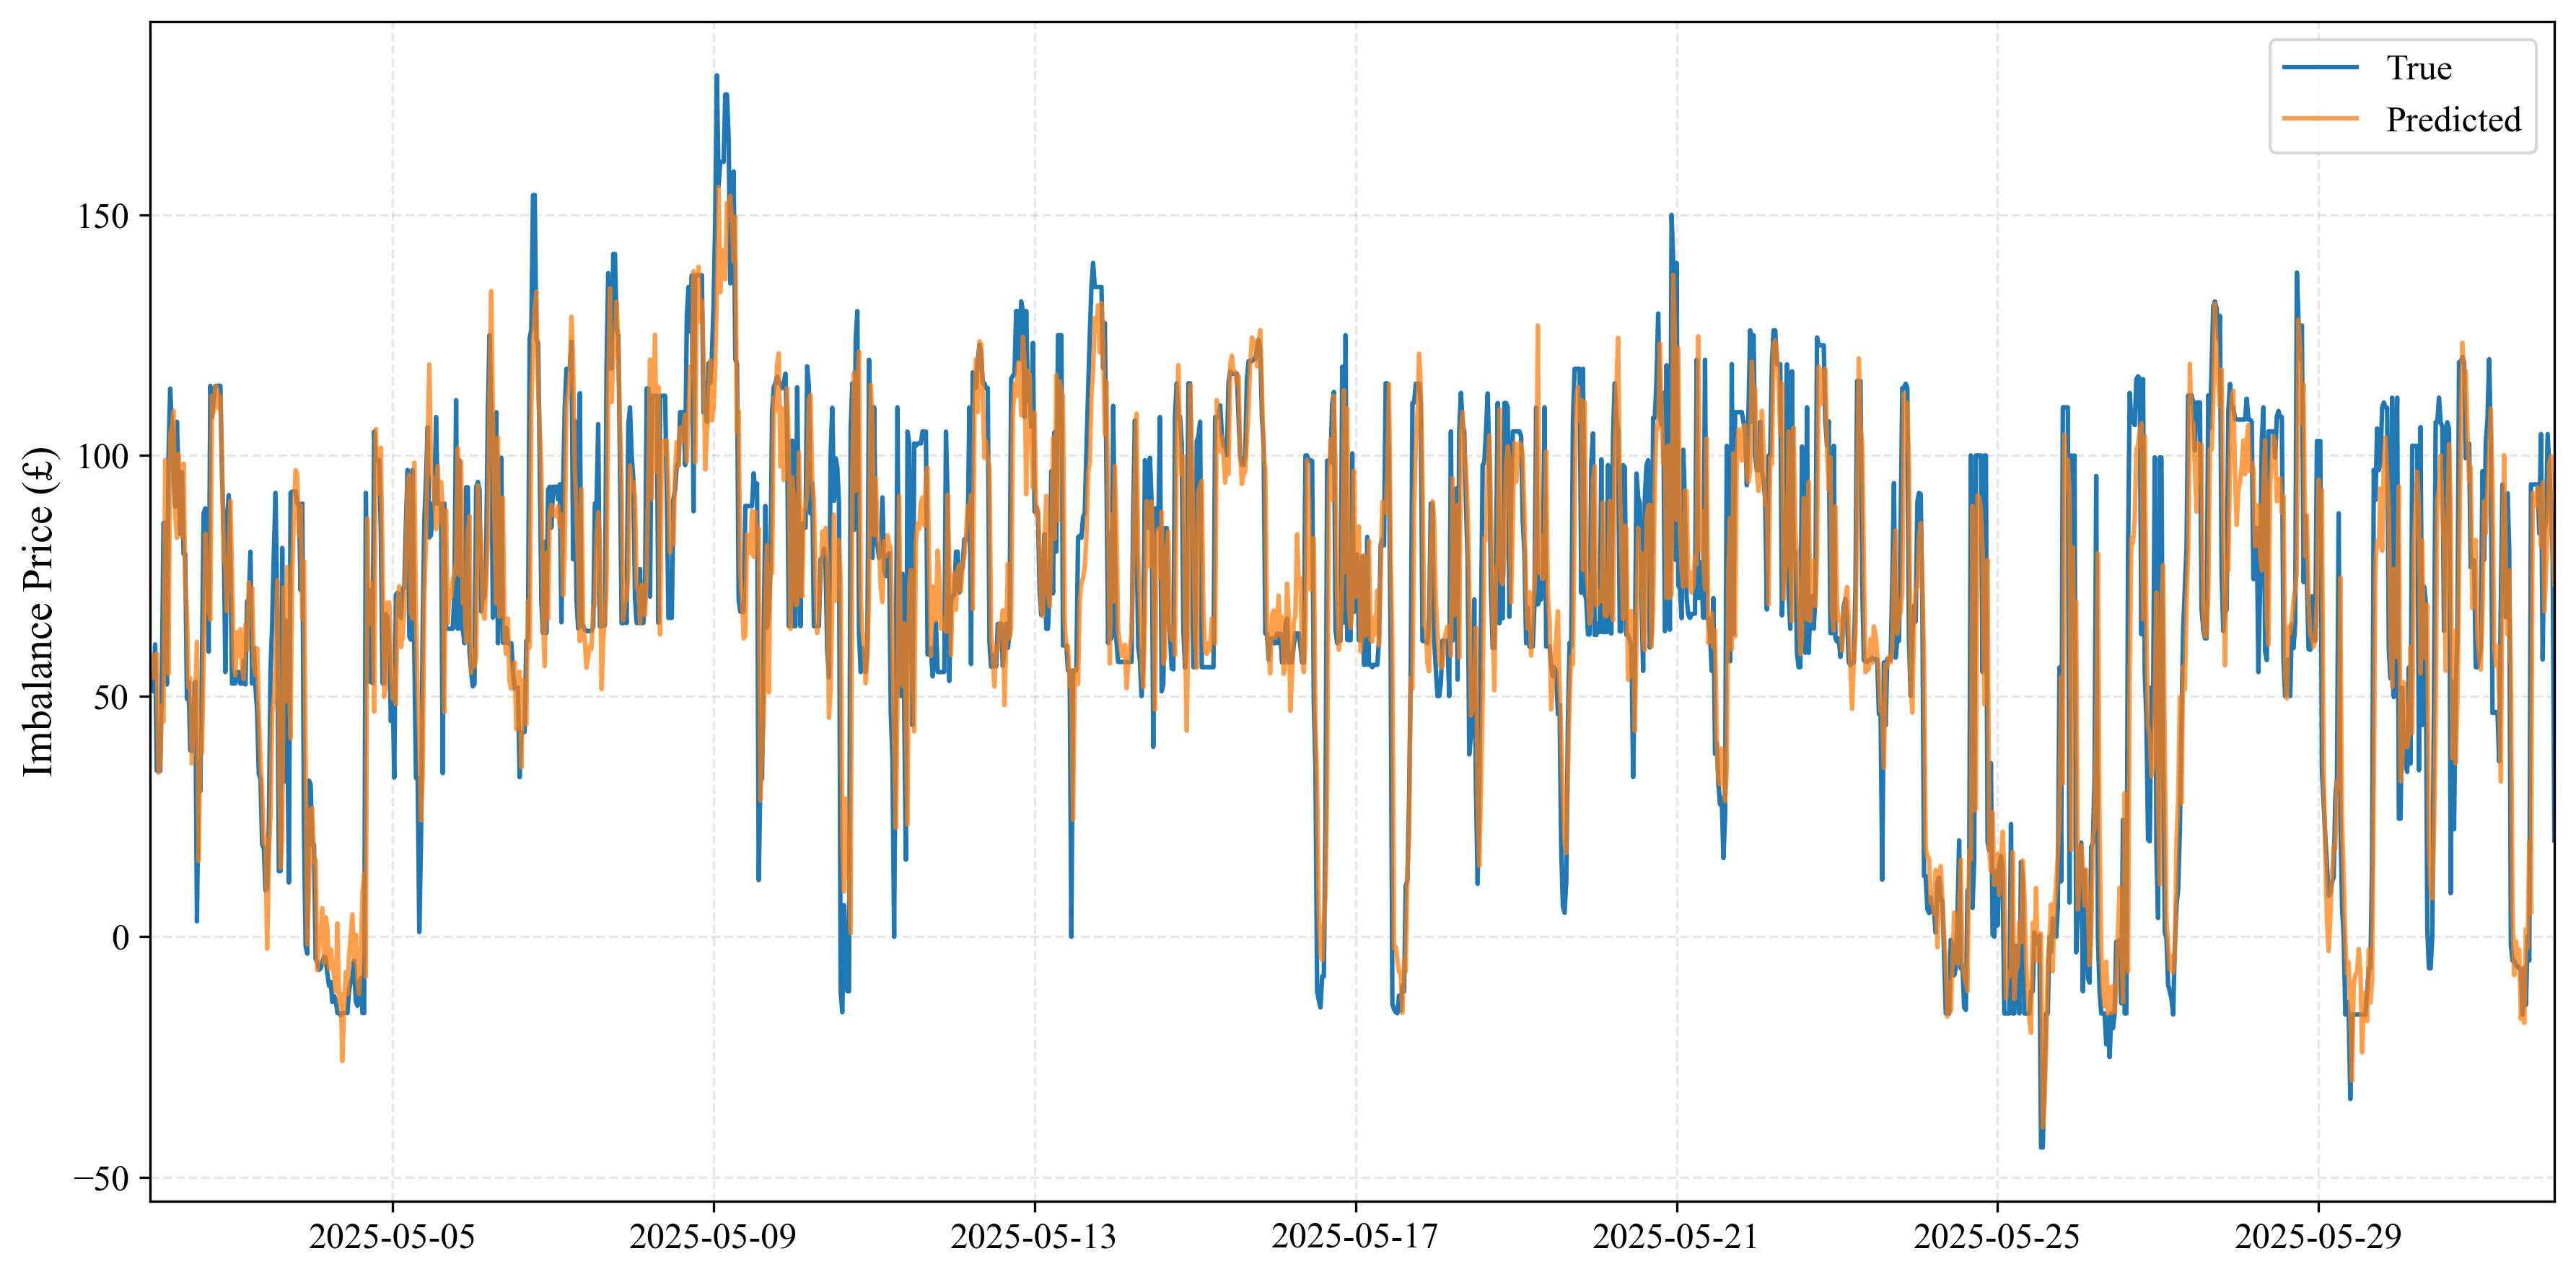

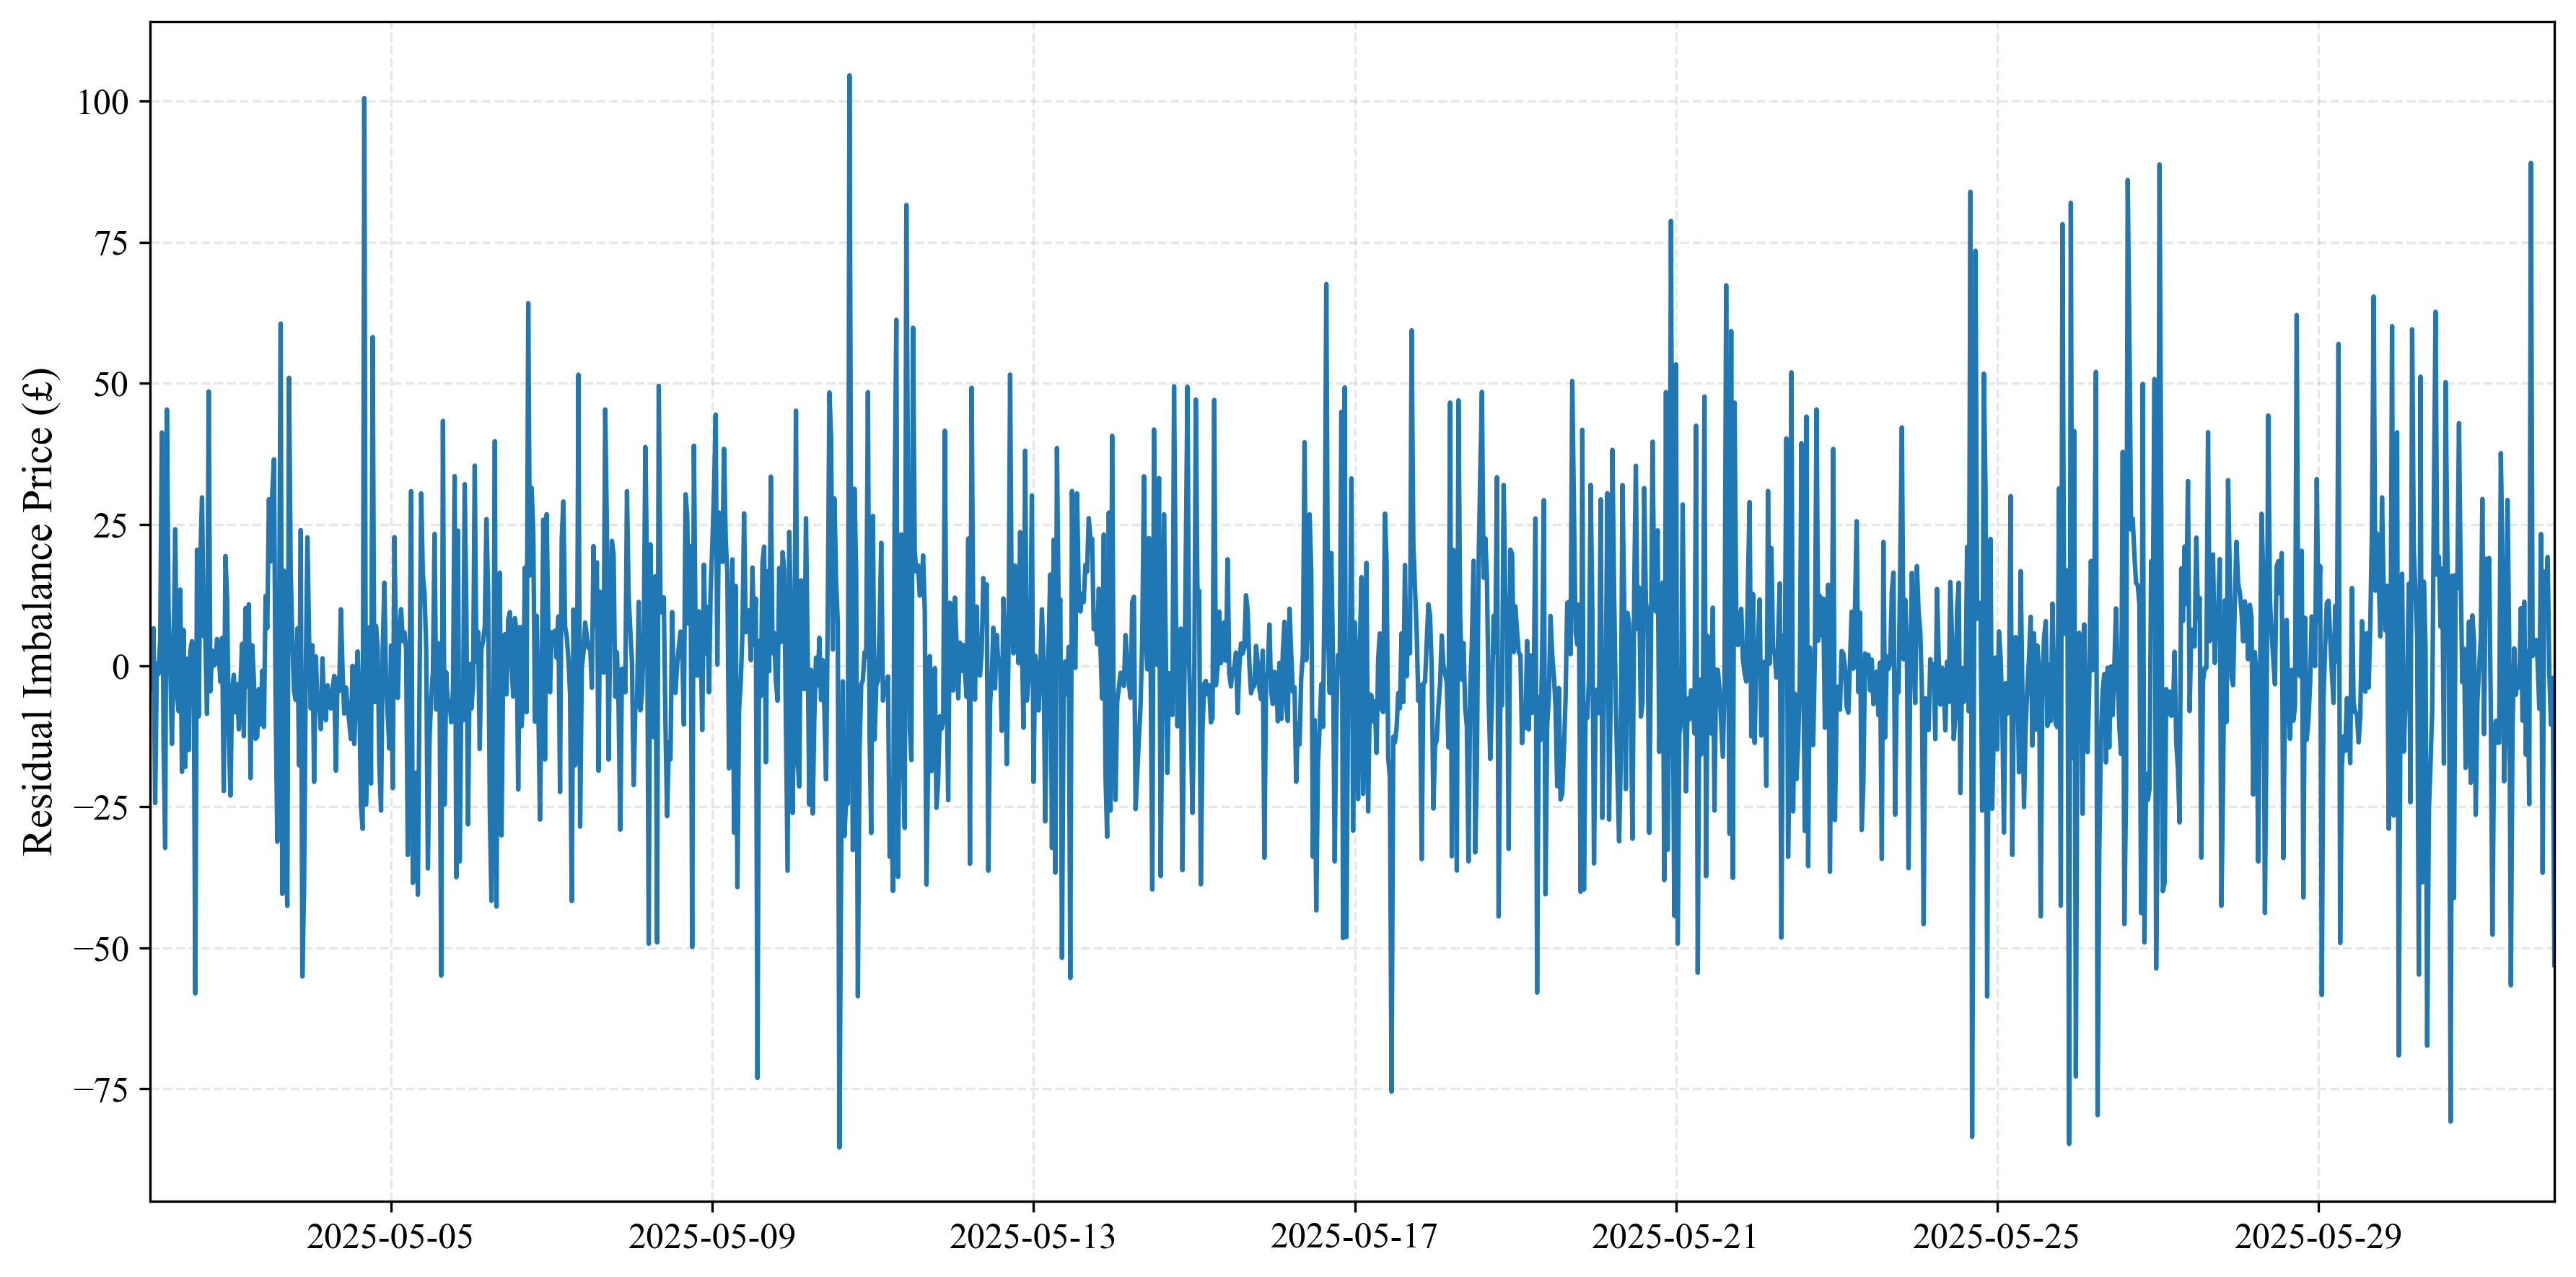

In [10]:
plt.figure(figsize=(12,6))
plt.plot(test_df.index[seq_len - 1 + horizon:], trues_orig, label="True", linewidth=1.5)
plt.plot(test_df.index[seq_len - 1 + horizon:], preds_orig, label="Predicted", linewidth=1.5, alpha=0.75)
plt.legend()
plt.ylabel("Imbalance Price (£)")
plt.xlim(test_df.index[seq_len-1], test_df.index[-1])
plt.tight_layout()
plt.savefig(os.path.join(plots_dir, "true_vs_predicted_over_time.png"), dpi=300)
plt.show()

plt.figure(figsize=(12,6))
plt.plot(test_df.index[seq_len - 1 + horizon:], trues_orig - preds_orig, linewidth=1.5)
plt.ylabel("Residual Imbalance Price (£)")
plt.xlim(test_df.index[seq_len - 1 + horizon], test_df.index[-1])
plt.tight_layout()
plt.savefig(os.path.join(plots_dir, "residuals_over_time.png"), dpi=300)
plt.show()

# SHAP

In [18]:
# ─── SHAP BACKGROUND via PCA + K-Means ───────────────────────────────────
import os, joblib
import numpy as np
import torch
import torch.nn as nn
import shap
from sklearn.decomposition import PCA
from sklearn.cluster    import KMeans
from torch.utils.data   import DataLoader

def unscale_shap(shap_arr, baseline, scaler):
    # (same as before)
    if hasattr(scaler, "max_abs_"):
        delta, offset = scaler.max_abs_[0], 0.0
    elif hasattr(scaler, "data_max_") and hasattr(scaler, "data_min_"):
        delta = scaler.data_max_[0] - scaler.data_min_[0]
        offset = scaler.data_min_[0]
    elif hasattr(scaler, "scale_") and hasattr(scaler, "mean_"):
        delta, offset = scaler.scale_[0], scaler.mean_[0]
    elif hasattr(scaler, "center_") and hasattr(scaler, "scale_"):
        delta, offset = scaler.scale_[0], scaler.center_[0]
    else:
        raise ValueError(f"Unsupported scaler: {type(scaler)}")
    return shap_arr * delta, baseline * delta + offset

# ─── User settings ──────────────────────────────────────────────────────
K          = 300  # number of backgrounds
n_components = 20  # PCA dims
shap_path  = os.path.join(base_dir, "shap_data.joblib")
need_compute = True

# ─── Try loading if exists & K match ────────────────────────────────────
if os.path.exists(shap_path):
    shp = joblib.load(shap_path)
    if shp.get("K")==K and shp.get("n_pca")==n_components:
        shap_arr_gbp = shp["shap_arr_gbp"]
        baseline_gbp = shp["baseline_gbp"]
        print(f"✅ Loaded SHAP (K={K}, PCA={n_components}) from {shap_path}")
        need_compute = False
    else:
        print(f"⚠️ Recomputing SHAP: found K={shp.get('K')}, PCA={shp.get('n_pca')}")

# ─── Compute if needed ──────────────────────────────────────────────────
if need_compute:
    # A) Build and flatten windows
    def make_windows(X, L):
        return np.stack([X[i:i+L] for i in range(len(X)-L+1)], axis=0)

    X_tr_np = transformer.transform(train_df[all_feats])  # (N, n_feats)
    seq_len = summary["hyperparams"]["seq_len"]
    n_feats = X_tr_np.shape[1]

    X_tr_w = make_windows(X_tr_np, seq_len)               # (N_w, L, F)
    flat   = X_tr_w.reshape(len(X_tr_w), -1)               # (N_w, L*F)
    print(f"DEBUG: windows={X_tr_w.shape}, flat={flat.shape}")

    # B) PCA reduction
    target_var = 0.80
    pca_full = PCA().fit(flat)
    cumvar   = np.cumsum(pca_full.explained_variance_ratio_)
    n_components = np.searchsorted(cumvar, target_var) + 1
    print(f"DEBUG: need {n_components} components for {target_var*100:.0f}% variance "
          f"(got {cumvar[n_components-1]*100:.2f}%)")

    pca = PCA(n_components=n_components, random_state=0)
    flat_p = pca.fit_transform(flat)
    print(f"DEBUG: PCA retained {pca.explained_variance_ratio_.sum():.2%} variance")

    # C) KMeans in PCA space
    km = KMeans(n_clusters=K, random_state=0, n_init=10).fit(flat_p)
    centers_p = km.cluster_centers_                        # (K, n_components)

    # D) Inverse to original space & reshape
    cents_flat   = pca.inverse_transform(centers_p)        # (K, L*F)
    bg_windows   = cents_flat.reshape(K, seq_len, n_feats) # (K, L, F)
    bg_tensor    = torch.from_numpy(bg_windows.astype(np.float32)).to(device)
    print(f"DEBUG: bg_tensor={bg_tensor.shape}")

    # E) Build test tensor
    test_ds      = LSTMDataset(
        transformer.transform(test_df[all_feats]),
        scaler_y.transform(test_df["Imbalance Price"].values.reshape(-1,1)).flatten(),
        seq_len
    )
    test_loader  = DataLoader(test_ds, batch_size=len(test_ds), shuffle=False)
    test_windows,_ = next(iter(test_loader))
    test_tensor  = test_windows.to(device)
    print(f"DEBUG: test_tensor={test_tensor.shape}")

    # F) SHAP Explainer
    class ShapModelWrapper(nn.Module):
        def __init__(self, base_model):
            super().__init__()
            self.base = base_model
        def forward(self, x):
            y = self.base(x)
            return y.unsqueeze(1) if y.dim()==1 else y

    wrapped   = ShapModelWrapper(model).to(device).eval()
    explainer = shap.DeepExplainer(wrapped, bg_tensor)
    raw_vals  = explainer.shap_values(test_tensor, check_additivity=False)
    shap_arr_s = np.squeeze(raw_vals, axis=-1)
    baseline_s = explainer.expected_value[0]
    print(f"DEBUG: shap_arr_scaled={shap_arr_s.shape}, baseline={baseline_s:.4f}")

    # G) Un‐scale & Save
    shap_arr_gbp, baseline_gbp = unscale_shap(shap_arr_s, baseline_s, scaler_y)
    joblib.dump({
        "K":            K,
        "n_pca":        n_components,
        "shap_arr_gbp": shap_arr_gbp,
        "baseline_gbp": baseline_gbp
    }, shap_path, compress=3)
    print(f"✅ Computed & saved SHAP (K={K}, PCA={n_components}) to {shap_path}")


⚠️ Recomputing SHAP: found K=300, PCA=78
DEBUG: windows=(64273, 48, 10), flat=(64273, 480)
DEBUG: need 33 components for 80% variance (got 80.35%)
DEBUG: PCA retained 80.35% variance
DEBUG: bg_tensor=torch.Size([300, 48, 10])
DEBUG: test_tensor=torch.Size([1438, 48, 10])


/opt/anaconda3/envs/thesis/lib/python3.10/site-packages/shap/explainers/_deep/deep_pytorch.py:255: UserWarning: unrecognized nn.Module: LSTM
  warnings.warn(f"unrecognized nn.Module: {module_type}")
/opt/anaconda3/envs/thesis/lib/python3.10/site-packages/shap/explainers/_deep/deep_pytorch.py:255: UserWarning: unrecognized nn.Module: SeasonalAttn
  warnings.warn(f"unrecognized nn.Module: {module_type}")


DEBUG: shap_arr_scaled=(1438, 48, 10), baseline=0.0300
✅ Computed & saved SHAP (K=300, PCA=33) to models/1_SA_BiLSTM_MaxAbs_Huber_lr.0001_bs128_hs64_nl2_sl48_me200_p20/shap_data.joblib


## Plots per Feature

In [19]:
# Flatten into (test_length*48, num_feats)
vals_flat = shap_arr_gbp.reshape(-1, shap_arr_gbp.shape[-1])
feat_flat = test_tensor.cpu().numpy().reshape(-1, shap_arr_gbp.shape[-1])

print("shap_arr_gbp shape:", shap_arr_gbp.shape) # (1439, 48, num_feats)
print("test_tensor shape:", test_tensor.shape)   # (1439, 48, num_feats)

print("vals_flat shape:", vals_flat.shape)       # (1439*48, num_feats)
print("feat_flat shape:", feat_flat.shape)       # (1439*48, num_feats)

shap_arr_gbp shape: (1438, 48, 10)
test_tensor shape: torch.Size([1438, 48, 10])
vals_flat shape: (69024, 10)
feat_flat shape: (69024, 10)


### Beeswarm

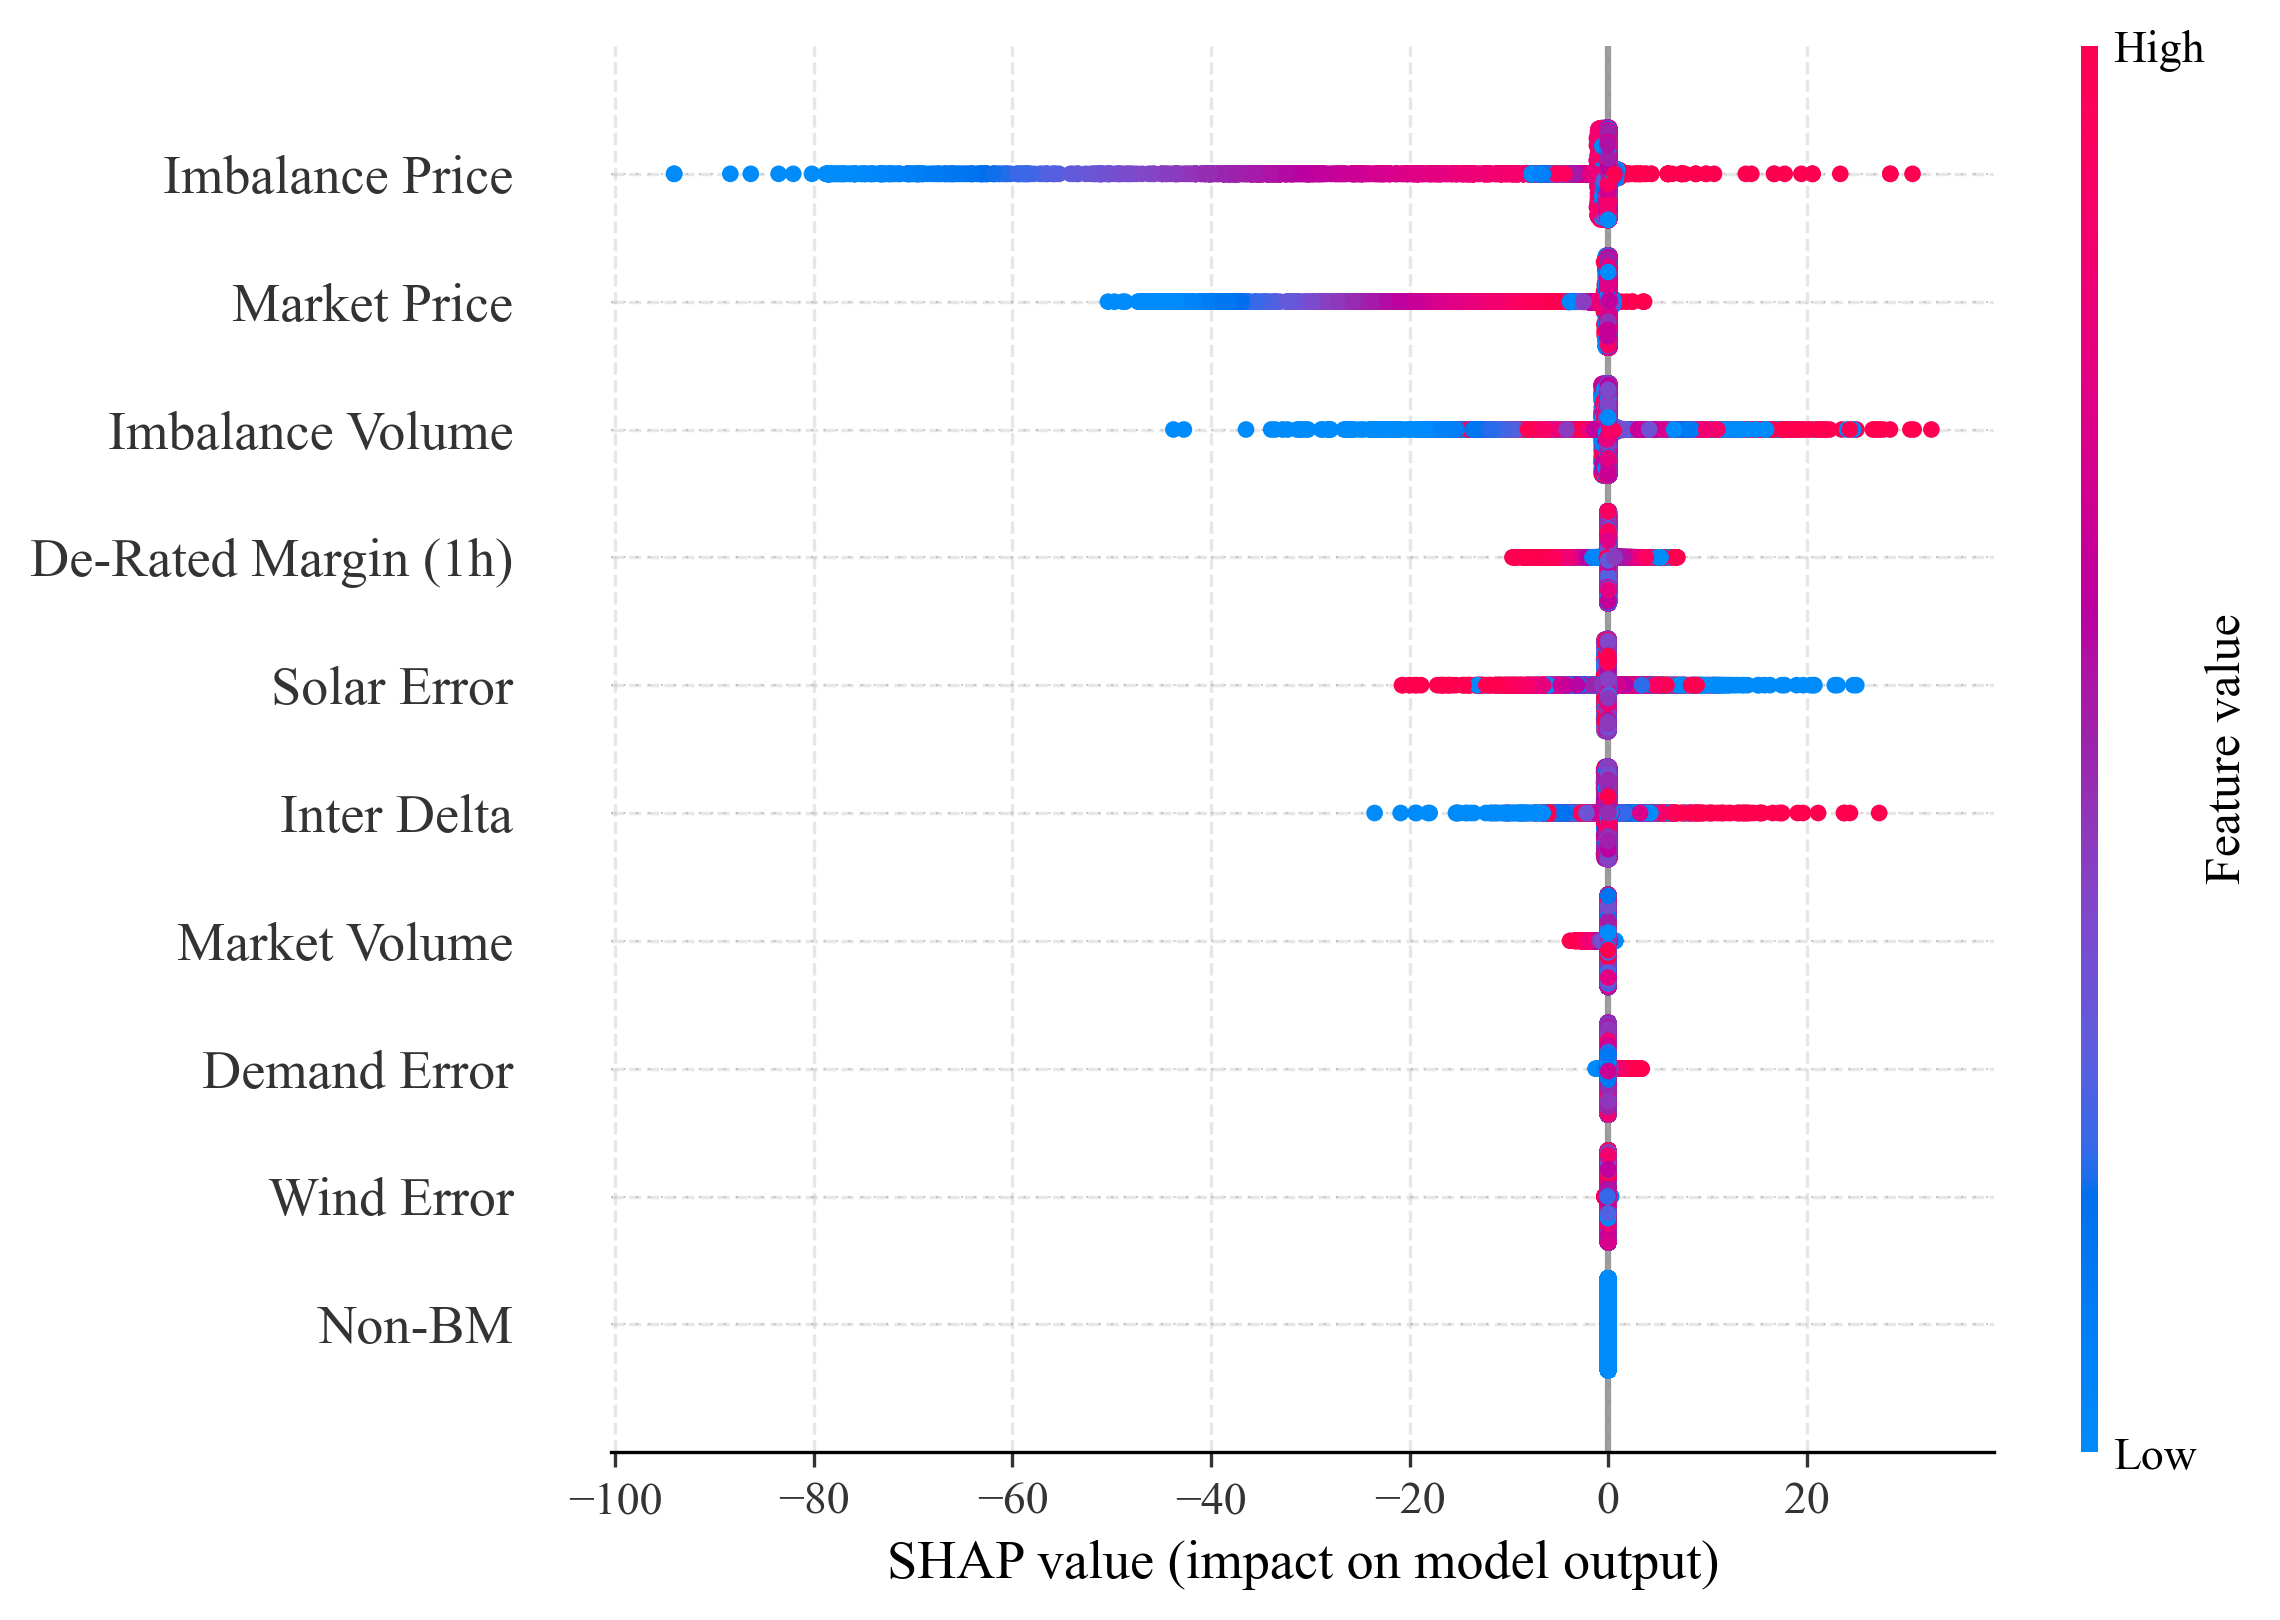

In [20]:
# shap_gbp has shape (1439, 48, num_feats)
# X_te_w  has shape (1439, 48, num_feats)

# Create fancy feature names for more readable plots
fancy_feats = all_feats.copy()
for i, feat in enumerate(all_feats):
    if feat == 'tod_sin':
        fancy_feats[i] = "Sin(Time of Day)"
    elif feat == 'tod_cos':
        fancy_feats[i] = "Cos(Time of Day)"
    elif feat == 'dow_sin':
        fancy_feats[i] = "Sin(Day of Week)"
    elif feat == 'dow_cos':
        fancy_feats[i] = "Cos(Day of Week)"
    elif feat == 'moy_sin':
        fancy_feats[i] = "Sin(Month of Year)"
    elif feat == 'moy_cos':
        fancy_feats[i] = "Cos(Month of Year)"

shap.initjs()
shap.summary_plot(
    vals_flat,
    feat_flat,
    feature_names=fancy_feats,
    max_display=15,
    plot_type="dot",
    show=False
)
plt.gcf()
plt.savefig(os.path.join(plots_dir, "shap_beeswarm.png"), dpi=300)


### Mean Absolute Shap Value

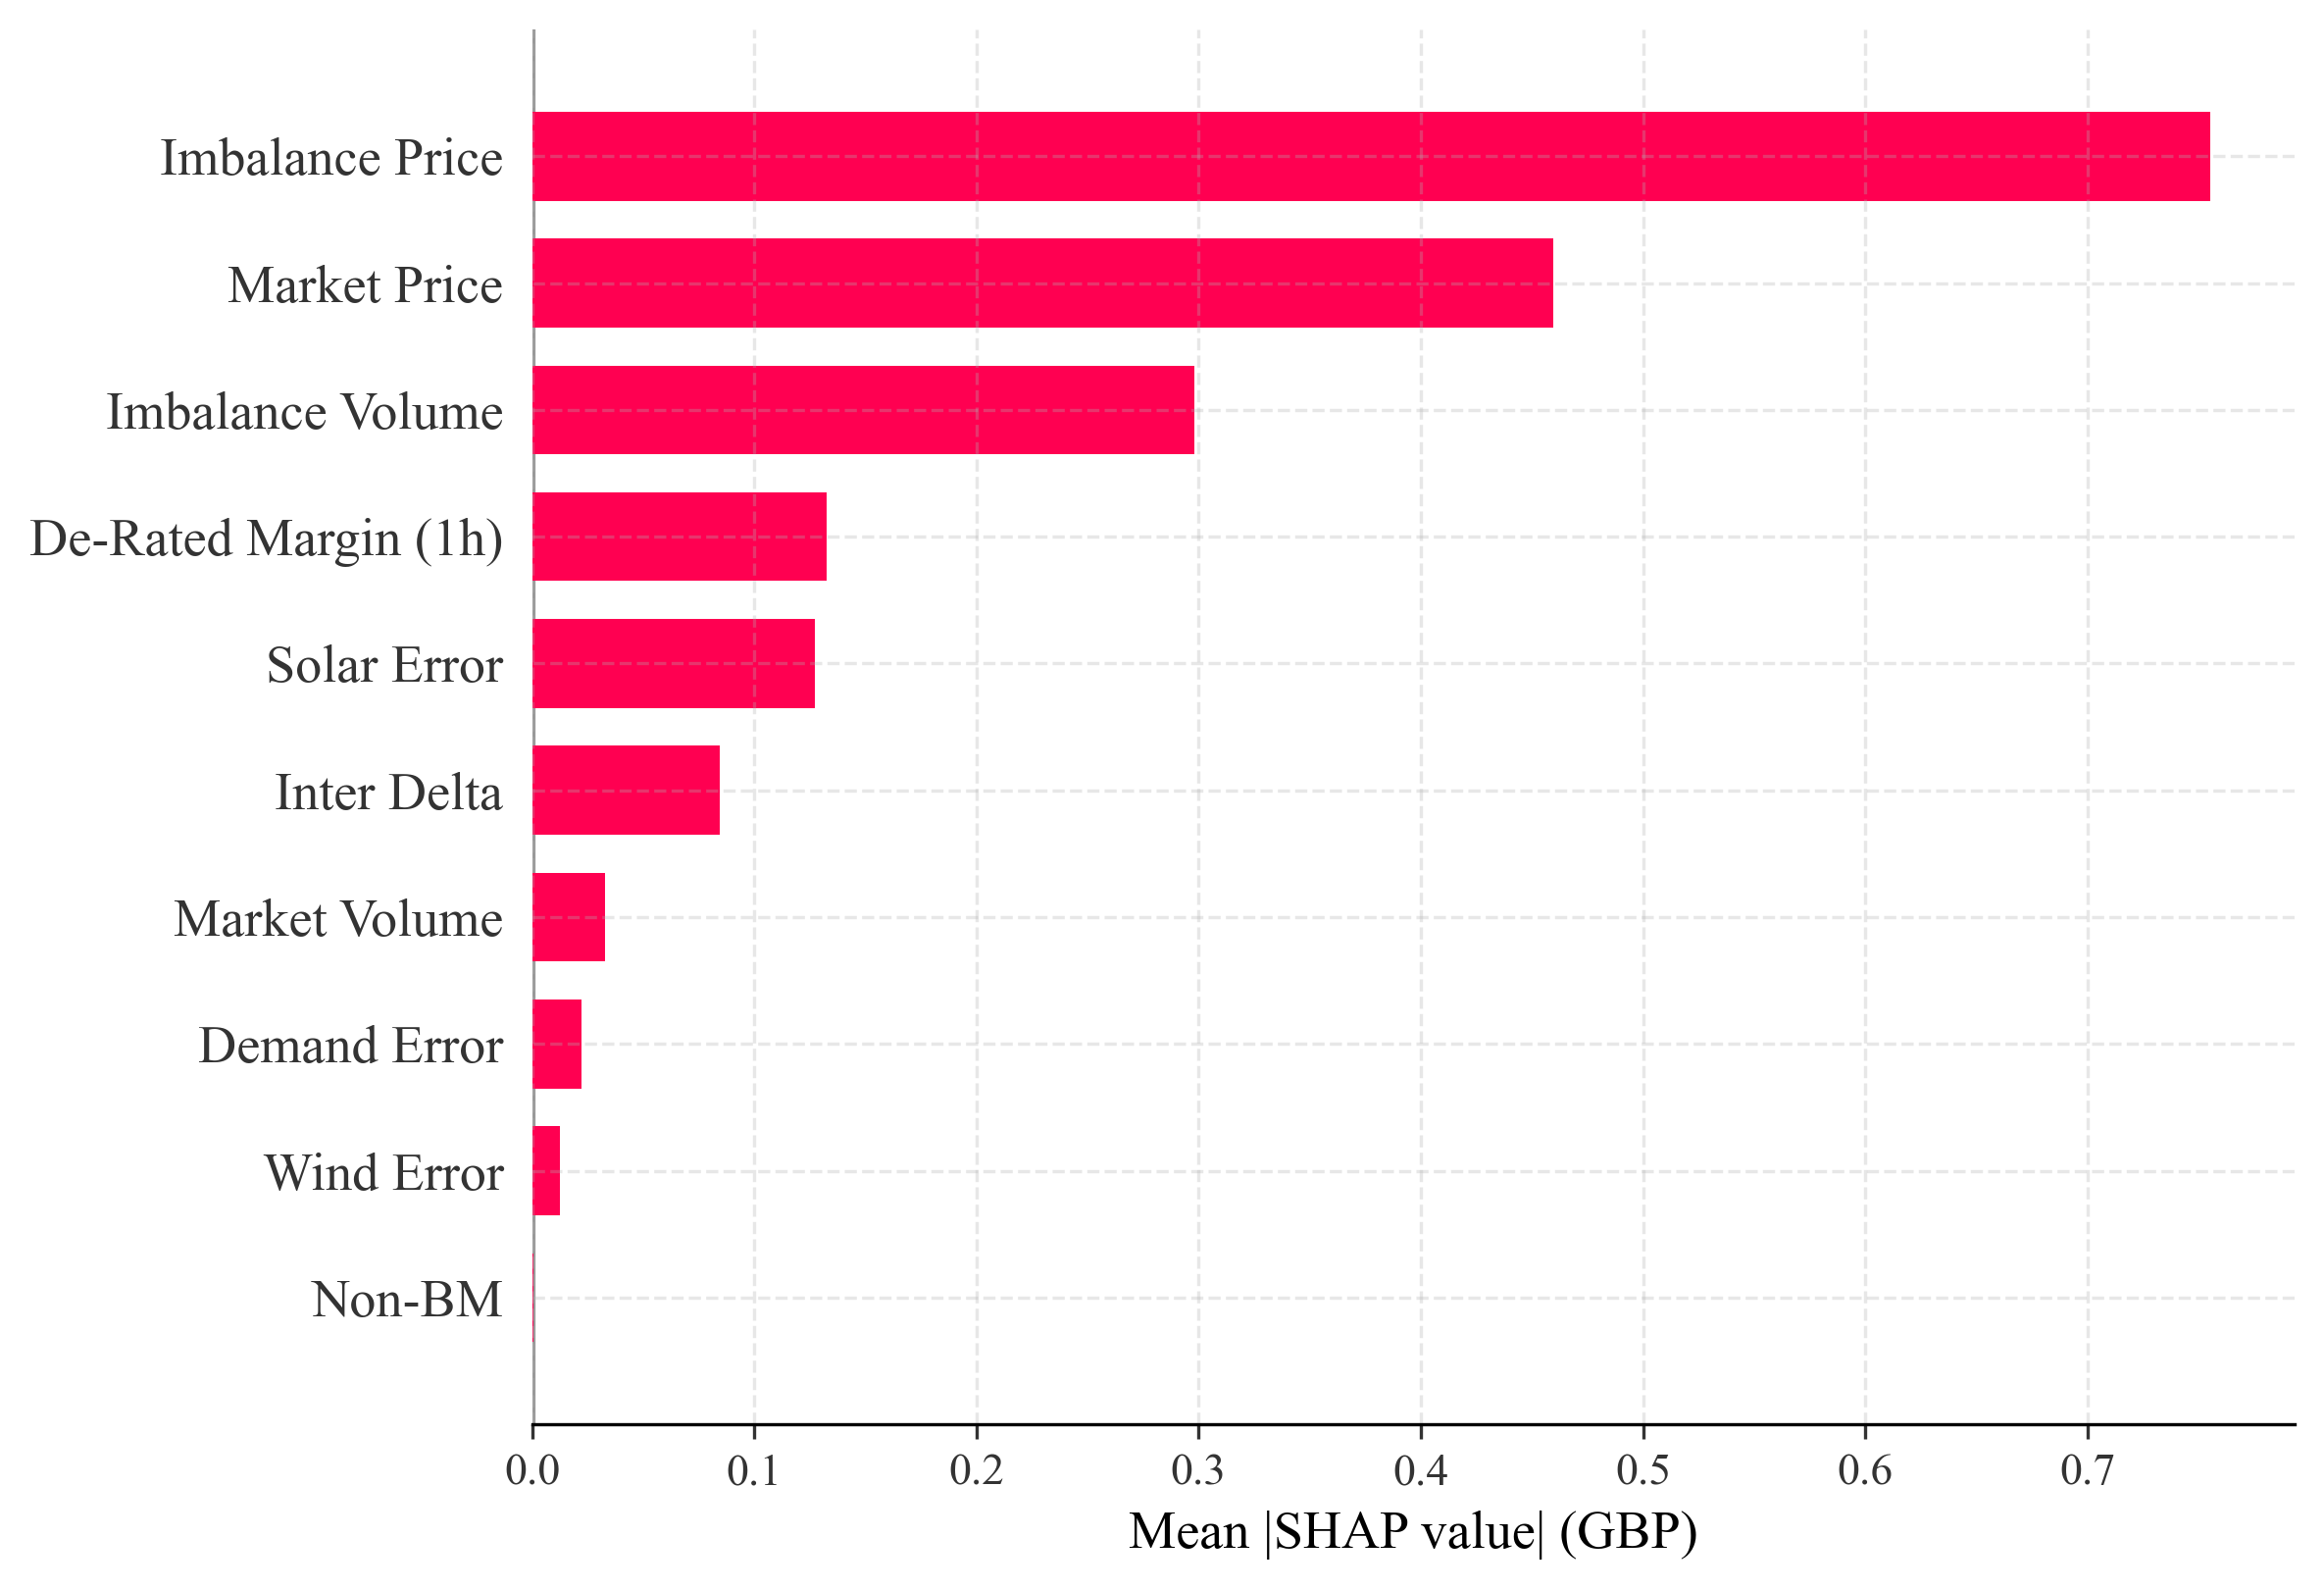

In [21]:
plt.figure(figsize=(10, 6))
shap.summary_plot(
    np.abs(vals_flat),        # pass in ALL absolute SHAP values
    feat_flat,                # or np.zeros_like(vals_flat) if you just want bars
    feature_names=fancy_feats,
    plot_type="bar",          # bar = mean(|SHAP|) per feature
    max_display=len(fancy_feats),
    show=False,
    color="#ff0051"           # override default color
)
plt.xlabel("Mean |SHAP value| (GBP)")
plt.ylabel("")               # keep only feature labels
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig(os.path.join(plots_dir, "shap_mean_bar.png"), dpi=300)
plt.show()

## Plots per Settlement Period

In [22]:
import numpy as np
import shap
import matplotlib.pyplot as plt

# 1) Compute per-window, per-lag shap by aggregating across features
shap_by_lag = np.mean(shap_arr_gbp, axis=2)  # shape: (n_windows, seq_len)

# 2) Debug prints
n_windows, seq_len = shap_by_lag.shape
print("DEBUG: shap_arr_gbp shape:", shap_arr_gbp.shape)
print("DEBUG: shap_by_lag shape:", shap_by_lag.shape)  # expect (n_windows, seq_len)

# 3) Define lag feature names
lag_names = [f"Lag {i+1}" for i in range(seq_len)]

DEBUG: shap_arr_gbp shape: (1438, 48, 10)
DEBUG: shap_by_lag shape: (1438, 48)


### Beeswarm

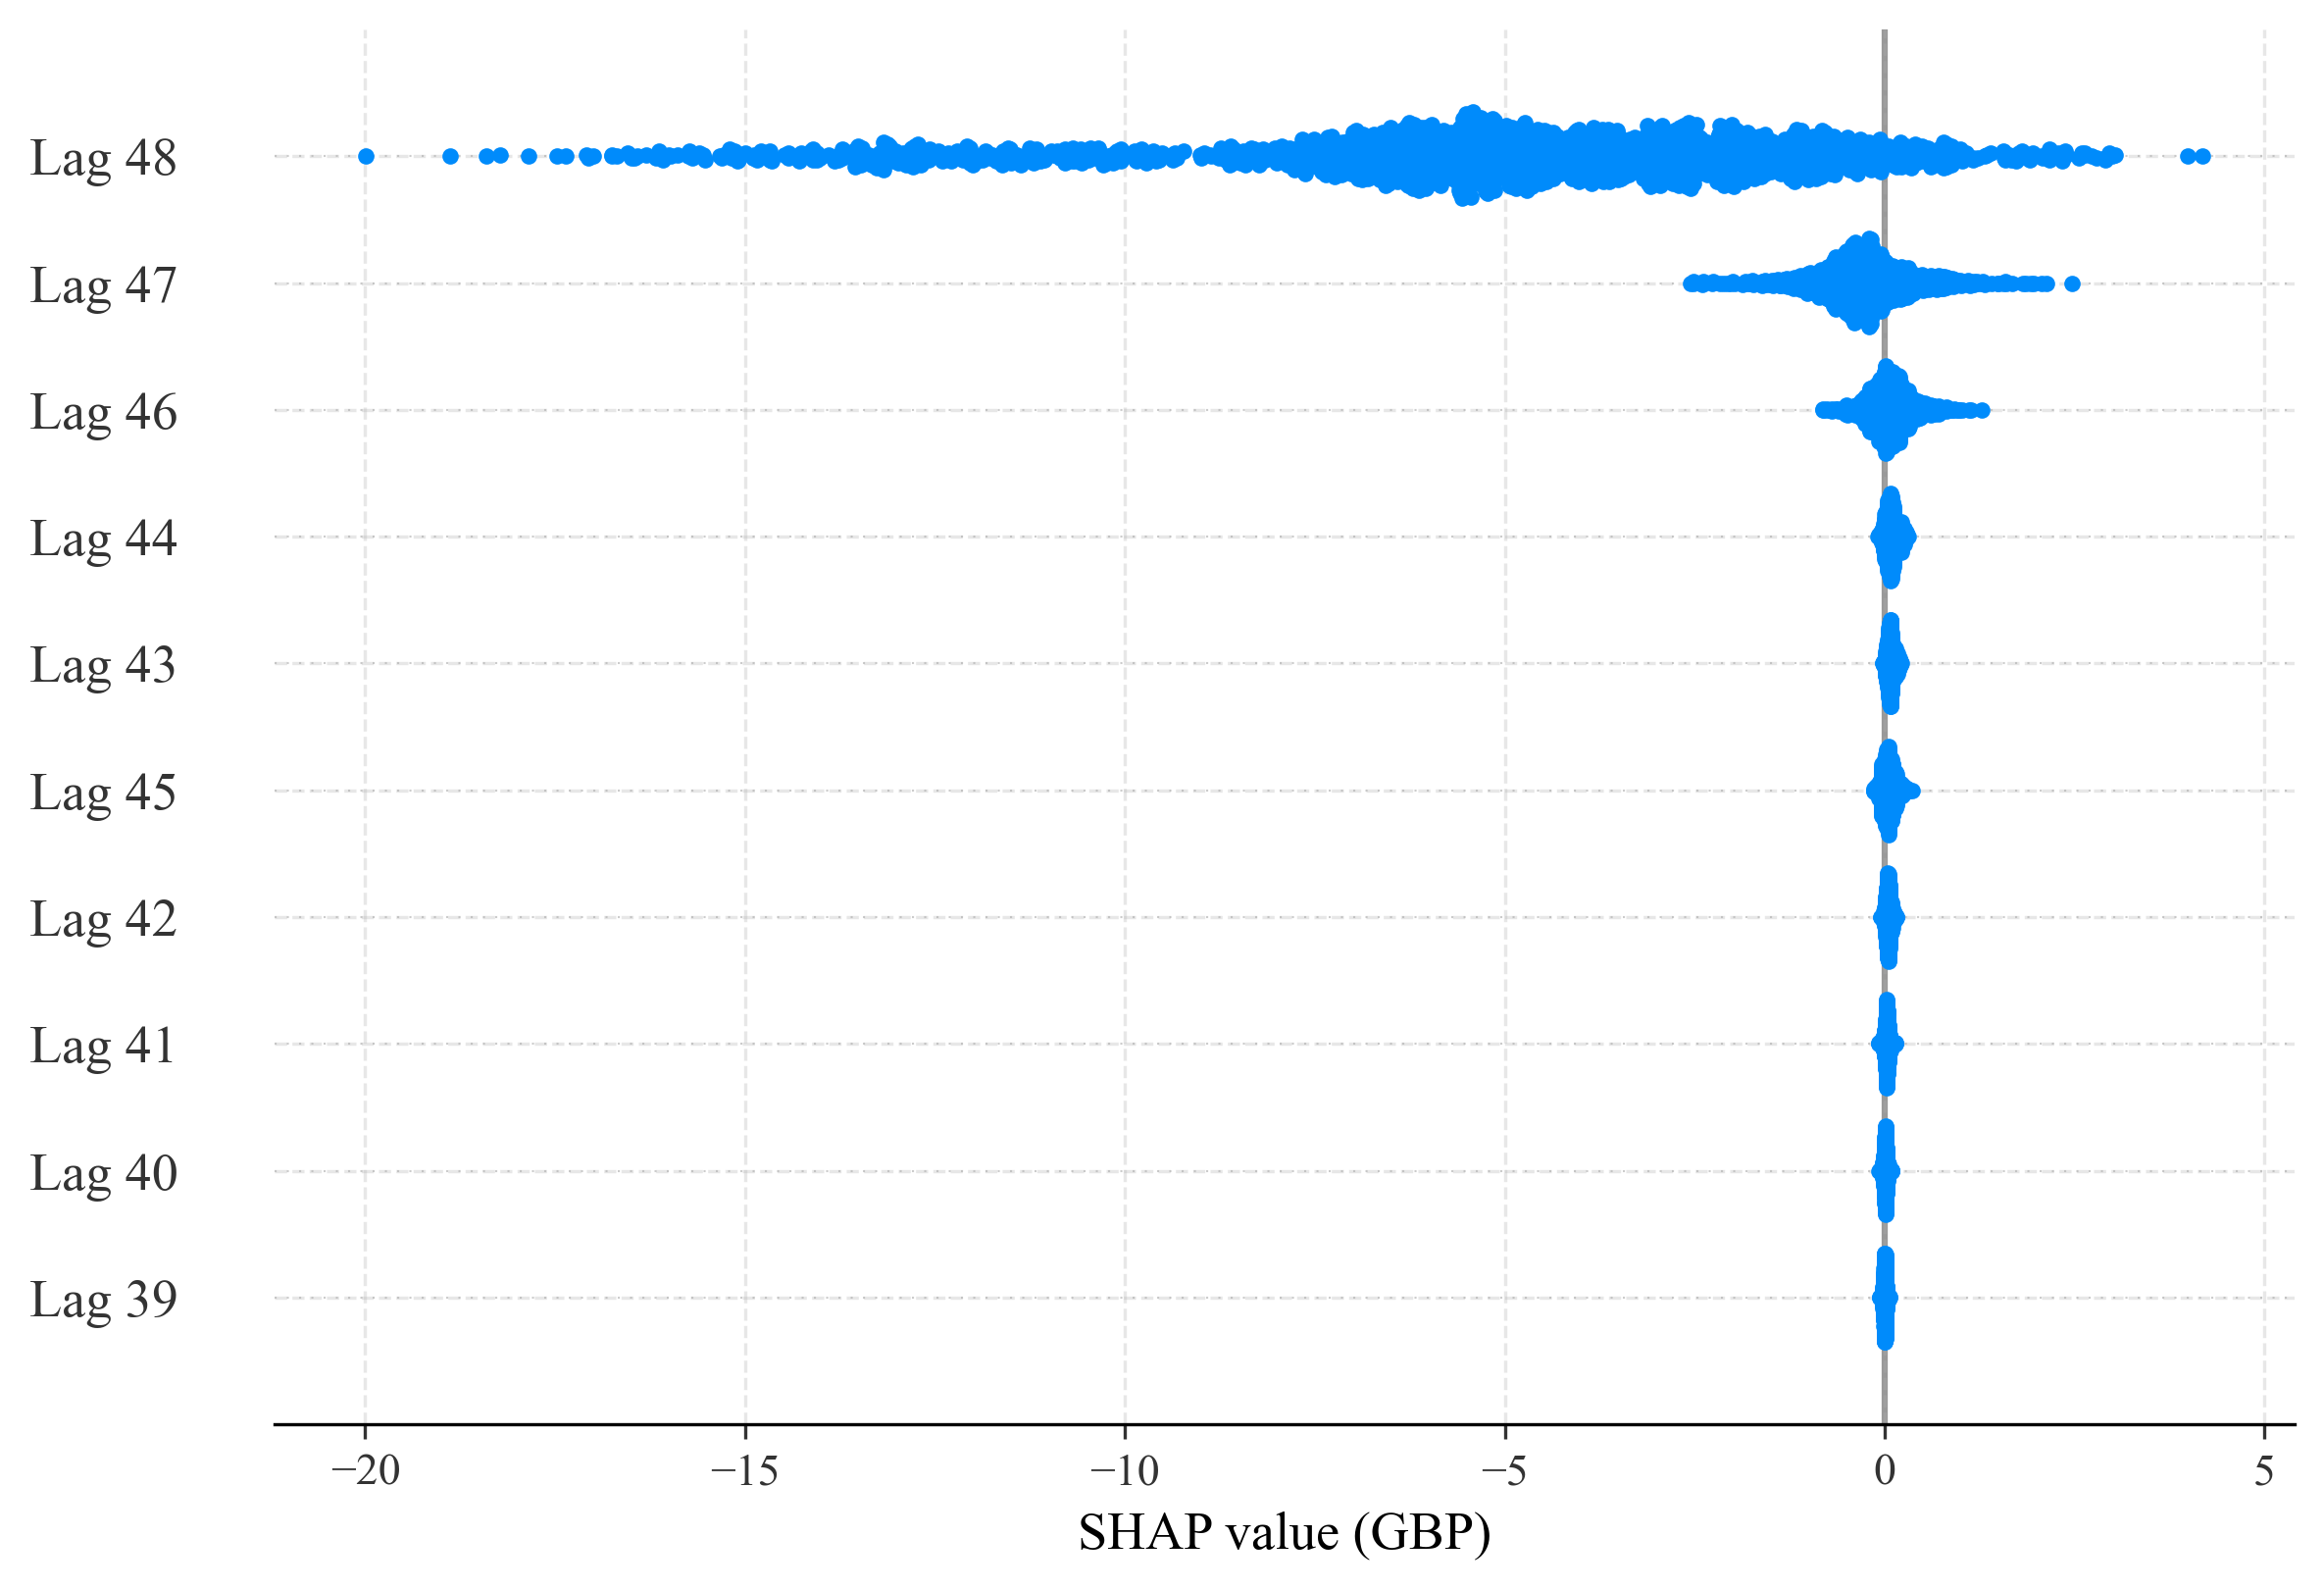

In [23]:
# 4) Beeswarm plot of raw SHAP by lag
shap.initjs()
plt.figure(figsize=(10, 6))
shap.summary_plot(
    shap_by_lag, 
    feature_names=lag_names,
    plot_type="dot",
    max_display=10,
    show=False
)
plt.xlabel("SHAP value (GBP)")
plt.ylabel("")  # keep lag names on y-axis
plt.tight_layout()
plt.savefig(os.path.join(plots_dir, "shap_beeswarm_by_lag.png"), dpi=300)
plt.show()

### Mean Absolute Shap Value

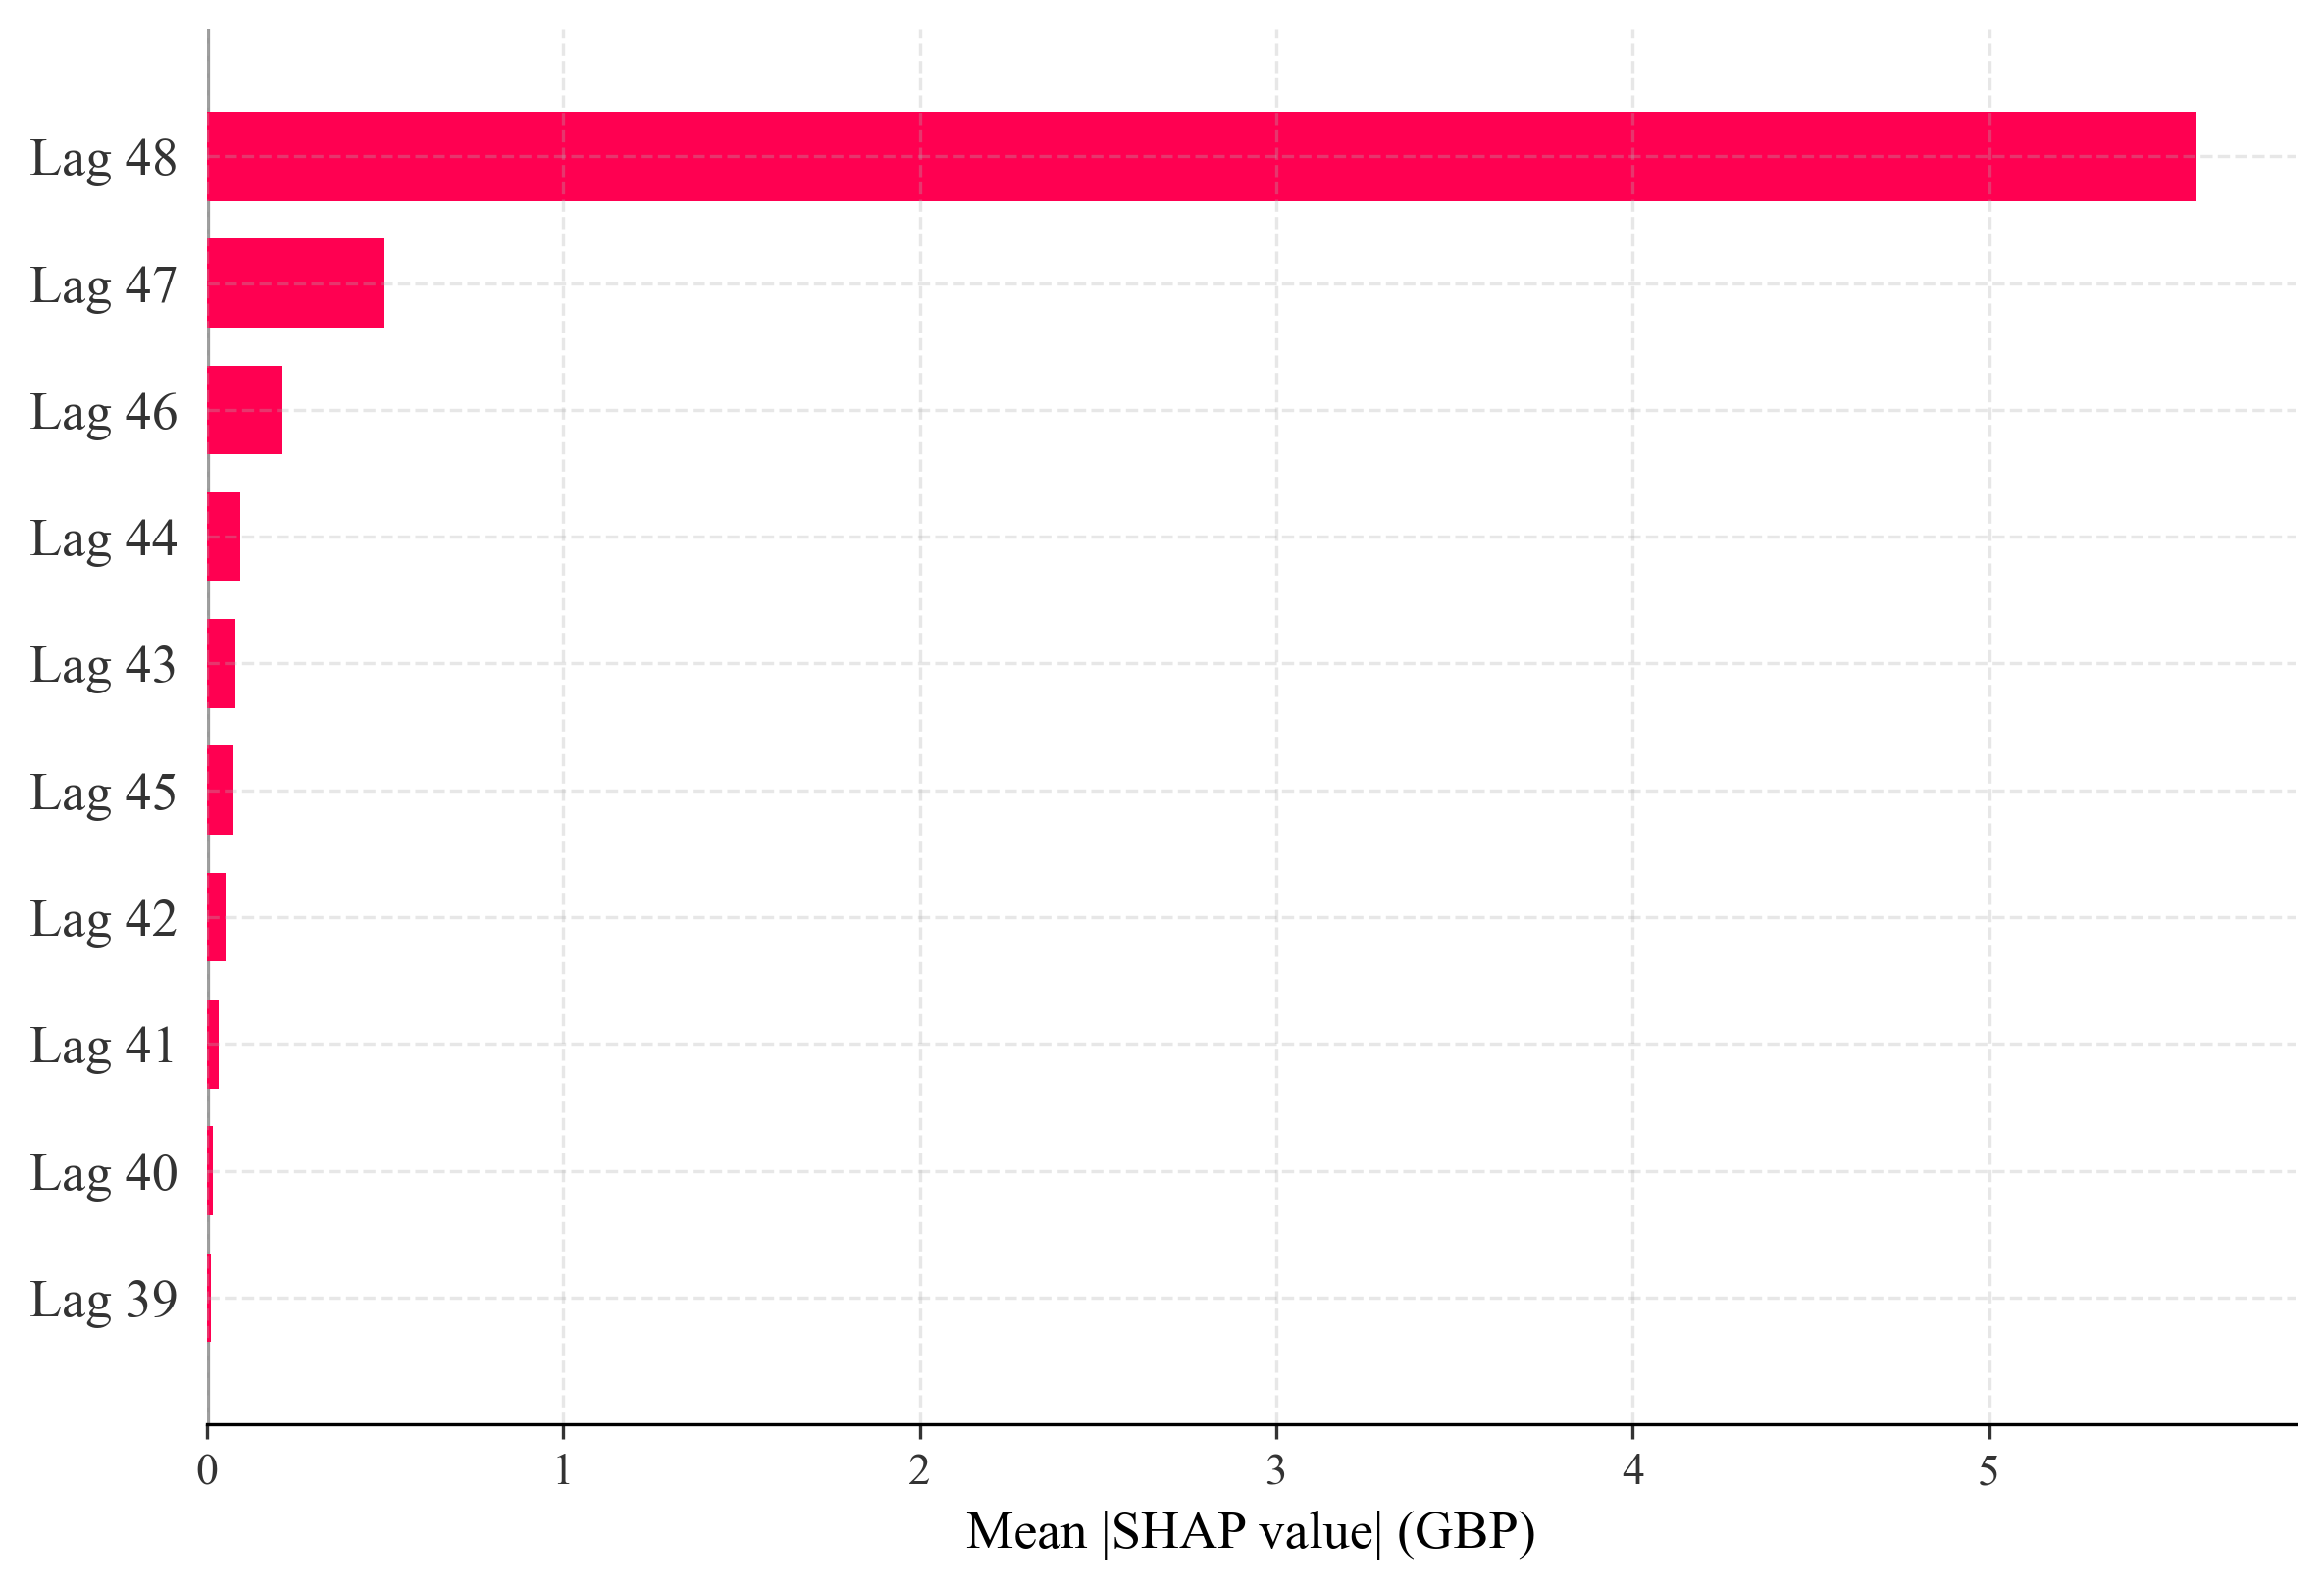

In [24]:
# 5) Bar plot of mean |SHAP| by lag
plt.figure(figsize=(10, 6))
shap.summary_plot(
    np.abs(shap_by_lag),
    feature_names=lag_names,
    plot_type="bar",
    max_display=10,
    show=False,
    color="#ff0051"
)
plt.xlabel("Mean |SHAP value| (GBP)")
plt.ylabel("")
plt.tight_layout()
plt.savefig(os.path.join(plots_dir, "shap_mean_bar_by_lag.png"), dpi=300)
plt.show()

## Downloading Files (COLAB ONLY)

In [ ]:
import shutil, os
from google.colab import files

shutil.make_archive(tag, 'zip', base_dir)
files.download(f"{tag}.zip")